In [77]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [193]:
class NeuralNetwork:
    def __init__(self, num_in, num_hidden, num_out, learning_rate, activation = 'sigmoid', classifier = True):
        self.lr = learning_rate
        #num output nodes
        self.num_out = num_out
        #list that maintains layers
        self.layers = []
        self.classifier = classifier
        np.random.seed(40)
        #randomly generate starting weights
        hidden = [{"weights": [np.random.random()-0.5 for j in range(num_in + 1)], "activation": activation} for i in range(num_hidden)]
        out = [{"weights": [np.random.random()-0.5 for j in range(num_hidden + 1)], "activation": "sigmoid"} for i in range(num_out)]
        self.layers.append(hidden)
        self.layers.append(out)
    
    #Relu activation, accepts inputs and applies relu function to each
    def relu_activation(self, inp):
        return max(0.0, inp)
    
    def weighted_sum(self, weights, inputs):
        lin_sum = weights[-1] #bias
        for i in range(len(inputs)):
            lin_sum += inputs[i]*weights[i]
        return lin_sum
    #Sigmoid activation + transfer. was running into issues with exp overflow when I didn't combine
    #these steps into a single method and attempted to separate into sigmoid activation followed by multiplying
    #by weights
    def sigmoid_activation(self, inp):
        return 1.0/(1.0 + np.exp(-inp))
    
    #applies derivative of sigmoid function to some values
    def derivative_sigmoid(self, sig):
        return sig * (1 - sig)
    
    #applies derivative of relu function to some values
    def derivative_relu(self, inp):
        return 1.0 if inp > 0 else 0.0
    
    def softmax(self, idx, weighted_sums):
        exp_sum = sum([np.exp(num) for num in weighted_sums])
        return np.exp(weighted_sums[idx])/exp_sum
    
    #forward propogate to make predictions by updating the 'out' field of each neuron
    def forward(self, input_vector):
        for layer in self.layers:
            out = []
            if layer != self.layers[len(self.layers) - 1]:
                for neuron in layer:
                    w_sum = self.weighted_sum(neuron['weights'], input_vector)
                    #apply sigmoid activation and weights to make neuron's prediction
                    if neuron['activation'] == 'sigmoid':
                        neuron['out'] = self.sigmoid_activation(w_sum)
                    #apply relu activation and weights to make prediction
                    else:
                        neuron['out'] = self.relu_activation(w_sum)
                    out.append(neuron['out'])
            else:
                if self.classifier:
                    w_sums = [self.weighted_sum(neuron['weights'], input_vector) for neuron in layer]
                    for i in range(len(layer)):
                        neuron = layer[i]
                        neuron['out'] = self.softmax(i, w_sums)
                        out.append(neuron['out'])
                else:
                    for neuron in layer:
                        neuron['out'] = self.weighted_sum(neuron['weights'], input_vector)
                        out.append(neuron['out'])
            #represents the input into the next layer, which is a list of all the current layer's neurons' outputs
            input_vector = out
        #return the predictions for the last layer
        return input_vector
    
    #back propogate to train the NN on the data
    def back_propogate(self, expected):
        #move backwards, starting from the last layer to the first
        for i in range(len(self.layers) - 1, -1, -1):
            layer = self.layers[i]
            #the errors on each neuron
            errors = []
            if i != len(self.layers) - 1: #bias term
                for j in range(len(layer)):
                    error_sum = 0
                    for neuron in self.layers[i+1]:
                        error_sum += neuron['weights'][j] * neuron['delta']
                    errors.append(error_sum)
            else:
                for j in range(len(layer)):
                    errors.append(expected[j] - layer[j]['out'])
            #use the error times the derivative of the activation function to move towards the weights that minimmize
            #the error
            for j in range(len(layer)):
                neuron = layer[j]
                if self.classifier and layer == self.layers[-1]:
                    neuron['delta'] = errors[j]
                elif neuron['activation'] == 'sigmoid':
                    neuron['delta'] = errors[j] * self.derivative_sigmoid(neuron['out'])
                else:
                    #print(errors[j], neuron['out'])
                    neuron['delta'] = errors[j] * self.derivative_relu(neuron['out'])
    
    #update the weights of each node
    def update_w(self, row):
        for i in range(len(self.layers)):
            layer_input = row[:-1]
            #no error on the first layer (input layer)
            if i != 0:
                layer_input = [neuron['out'] for neuron in self.layers[i-1]]
            #use learning rate times the previously calculated delta value times the input into the layer
            #to step towards zero-loss weights in the delta direction with step size tuned by learning rate
            for neuron in self.layers[i]:
                for j in range(len(layer_input)):
                    neuron['weights'][j] += self.lr * neuron['delta'] * layer_input[j]
            #bias term
            neuron['weights'][-1] += self.lr * neuron['delta']
    
    #train on data
    def train(self, train_data, test_data, max_epochs = 1000):
        self.graph(max_epochs)
        #update over epochs
        train_err_list = []
        test_err_list = []
        for epoch in range(max_epochs):
            train_epoch_error = 0
            test_epoch_error = 0
            
            #training data
            for row in train_data:
                #make predictions using current model
                epoch_out = self.forward(row)
                if self.classifier:
                    #get error of those predictions
                    expected = int(row[-1])
                    #ce loss
                    train_epoch_error += -np.log(epoch_out[expected])
                    expected_out_prob = [0] * len(epoch_out)
                    expected_out_prob[expected] = 1
                else:
                    expected_out_prob = [row[-1]]
                    print(expected_out_prob, epoch_out)
                    train_epoch_error += (expected_out_prob[0] - epoch_out[0])**2
                
                #update the weights based on those calculated errors
                
                self.back_propogate(expected_out_prob)
                self.update_w(row)   
            
            train_err_list.append(train_epoch_error/len(train_data))
            #plot error of this epoch
            #plt.plot(epoch, train_epoch_error/len(train_data), 'ro', label = "training")
            
            #test data
            for row in test_data:
                #make prediction based on current model
                predicted = self.predict(row)
                test_epoch_error += (predicted - row[-1]) ** 2
                
            test_err_list.append(test_epoch_error/len(test_data))
            #plot performance on test data
            #plt.plot(epoch, test_epoch_error/len(test_data), 'bo', label = "test")
        plt.plot(range(max_epochs), train_err_list,label = "training")
        plt.plot(range(max_epochs), test_err_list,label = "testing")
        plt.legend()
    #predict label of given row of data
    def predict(self, row):
        out_probs = self.forward(row)
        max_prob = float('-inf')
        max_ind = -1
        for i in range(len(out_probs)):
            if out_probs[i] > max_prob:
                max_ind = i
                max_prob = out_probs[i]
        return max_ind
    
    #set up the graph
    def graph(self, max_epochs):
        plt.xlim(0, max_epochs)
        plt.xlabel("epochs")
        plt.ylabel("mean squared error")

In [190]:
raw_data = np.genfromtxt('iris.data', delimiter=',', dtype = None, encoding = None)
num_label_data = []

iris_dict = {
    "Iris-setosa": 0,
    "Iris-versicolor": 1,
    "Iris-virginica": 2
}

for row in raw_data:
    sep_len, sep_width, pet_len, pet_width, label = row
    label = iris_dict[label]
    #using the max of each attribute (provided in iris.names on the dataset) to normalize
    sep_len /= 7.6
    sep_width /= 4.4
    pet_len /= 6.9
    pet_width /= 2.5
    num_label_data.append((sep_len, sep_width, pet_len, pet_width, int(label)))

np.random.shuffle(num_label_data)

train_test_spl = int(len(raw_data) * 0.85)
train = np.array(num_label_data[:train_test_spl])
test = np.array(num_label_data[train_test_spl:])

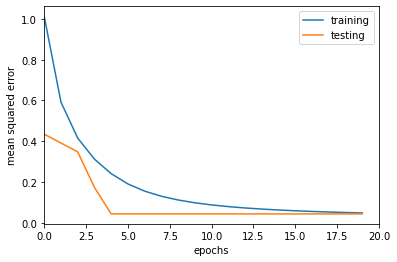

In [196]:
net = NeuralNetwork(4, 20, 3, 0.2, activation = 'sigmoid')
net.train(train, test, max_epochs = 20)

In [192]:
import pandas as pd
from sklearn import preprocessing

raw_data = pd.read_csv('forestfires.csv')
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
day_map = {'sun': 1, 'mon': 2, 'tue': 3, 'wed':4, 'thu':5, 'fri':6, 'sat': 7}
raw_data.month = raw_data.month.map(month_map)
raw_data.day = raw_data.day.map(day_map)

inp = raw_data.values
min_max_scaler = preprocessing.MinMaxScaler()
inp = min_max_scaler.fit_transform(inp)
np.random.shuffle(inp)

train_test_spl_reg = int(len(inp) * 0.85)
train_reg = np.array(inp[:train_test_spl])
test_reg = np.array(inp[train_test_spl:])

[0.032892083165267136] [-0.39858800685914025]
[0.0] [-0.5567304105974904]
[0.04450698544241135] [-1.1974076785360166]
[0.0] [-7.677314846072305]
[0.00019251219243885445] [-259992.93000455026]
[0.0003300209013237505] [-1.0813033637553657e+37]
[0.0007058780389424664] [-1.992407681850803e+258]
[0.0] [nan]
[0.07585897106816765] [nan]
[0.010019801254079424] [nan]
[0.0] [nan]
[0.0] [nan]
[0.002099299622309413] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0013475853470719813] [nan]
[0.002236808331194309] [nan]
[0.0] [nan]
[0.19515235964944447] [nan]
[0.0] [nan]
[0.01406255729529537] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.006857100949726817] [nan]
[0.010377323897180156] [nan]
[0.007984672362582965] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.009176414506252062] [nan]
[0.0013384180998129882] [nan]
[0.08112097099482966] [nan]
[0.0] [nan]
[0.17029078508305526] [nan]
[0.0] [nan]
[0.09478016941072935] [nan]
[0.0] [nan]
[0.0] [nan]
[0.006435407575813135] [nan]
[0.00454695464046056

<ipython-input-186-be689b4b9730>:138: RuntimeWarning: overflow encountered in double_scalars
  train_epoch_error += (expected_out_prob[0] - epoch_out[0])**2
<ipython-input-186-be689b4b9730>:33: RuntimeWarning: overflow encountered in double_scalars
  return sig * (1 - sig)
<ipython-input-186-be689b4b9730>:97: RuntimeWarning: invalid value encountered in double_scalars
  neuron['delta'] = errors[j] * self.derivative_relu(neuron['out'])
<ipython-input-186-be689b4b9730>:110: RuntimeWarning: invalid value encountered in double_scalars
  neuron['weights'][j] += self.lr * neuron['delta'] * layer_input[j]
<ipython-input-186-be689b4b9730>:23: RuntimeWarning: invalid value encountered in double_scalars
  lin_sum += inputs[i]*weights[i]


 [nan]
[0.00603204869641744] [nan]
[0.012824978915331305] [nan]
[0.010138975468446335] [nan]
[0.047468006307066116] [nan]
[0.0] [nan]
[0.013099996333101096] [nan]
[0.08725385941109605] [nan]
[0.0] [nan]
[0.0004950313519856258] [nan]
[0.0014942613032158704] [nan]
[0.0] [nan]
[0.0] [nan]
[0.04546037915734664] [nan]
[0.006701257746323934] [nan]
[0.027795093689266987] [nan]
[0.00043086062117267426] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0053720068937699395] [nan]
[0.013457518976201826] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0792508525539951] [nan]
[0.011092369183381613] [nan]
[0.0] [nan]
[0.0009808954567122586] [nan]
[0.0] [nan]
[0.06486744160463497] [nan]
[0.009130578269957099] [nan]
[0.0] [nan]
[0.0] [nan]
[0.007352132301712441] [nan]
[0.008498038209086576] [nan]
[0.014337574713065161] [nan]
[0.012559128744820505] [nan]
[0.0] [nan]
[0.004226100986395805] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.007874665395475046] [nan]
[0.001961790913424517] [nan]
[0.0] [nan]
[0.00143009

[0.032892083165267136] [nan]
[0.0] [nan]
[0.04450698544241135] [nan]
[0.0] [nan]
[0.00019251219243885445] [nan]
[0.0003300209013237505] [nan]
[0.0007058780389424664] [nan]
[0.0] [nan]
[0.07585897106816765] [nan]
[0.010019801254079424] [nan]
[0.0] [nan]
[0.0] [nan]
[0.002099299622309413] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0013475853470719813] [nan]
[0.002236808331194309] [nan]
[0.0] [nan]
[0.19515235964944447] [nan]
[0.0] [nan]
[0.01406255729529537] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.006857100949726817] [nan]
[0.010377323897180156] [nan]
[0.007984672362582965] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.009176414506252062] [nan]
[0.0013384180998129882] [nan]
[0.08112097099482966] [nan]
[0.0] [nan]
[0.17029078508305526] [nan]
[0.0] [nan]
[0.09478016941072935] [nan]
[0.0] [nan]
[0.0] [nan]
[0.006435407575813135] [nan]
[0.004546954640460563] [nan]
[0.0006508745553885079] [nan]
[0.001989292655201496] [nan]
[0.009240585237065014] [nan]
[0.001576766528546808] 

[0.032892083165267136] [nan]
[0.0] [nan]
[0.04450698544241135] [nan]
[0.0] [nan]
[0.00019251219243885445] [nan]
[0.0003300209013237505] [nan]
[0.0007058780389424664] [nan]
[0.0] [nan]
[0.07585897106816765] [nan]
[0.010019801254079424] [nan]
[0.0] [nan]
[0.0] [nan]
[0.002099299622309413] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0013475853470719813] [nan]
[0.002236808331194309] [nan]
[0.0] [nan]
[0.19515235964944447] [nan]
[0.0] [nan]
[0.01406255729529537] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.006857100949726817] [nan]
[0.010377323897180156] [nan]
[0.007984672362582965] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.009176414506252062] [nan]
[0.0013384180998129882] [nan]
[0.08112097099482966] [nan]
[0.0] [nan]
[0.17029078508305526] [nan]
[0.0] [nan]
[0.09478016941072935] [nan]
[0.0] [nan]
[0.0] [nan]
[0.006435407575813135] [nan]
[0.004546954640460563] [nan]
[0.0006508745553885079] [nan]
[0.001989292655201496] [nan]
[0.009240585237065014] [nan]
[0.001576766528546808] 

[0.032892083165267136] [nan]
[0.0] [nan]
[0.04450698544241135] [nan]
[0.0] [nan]
[0.00019251219243885445] [nan]
[0.0003300209013237505] [nan]
[0.0007058780389424664] [nan]
[0.0] [nan]
[0.07585897106816765] [nan]
[0.010019801254079424] [nan]
[0.0] [nan]
[0.0] [nan]
[0.002099299622309413] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0013475853470719813] [nan]
[0.002236808331194309] [nan]
[0.0] [nan]
[0.19515235964944447] [nan]
[0.0] [nan]
[0.01406255729529537] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.006857100949726817] [nan]
[0.010377323897180156] [nan]
[0.007984672362582965] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.009176414506252062] [nan]
[0.0013384180998129882] [nan]
[0.08112097099482966] [nan]
[0.0] [nan]
[0.17029078508305526] [nan]
[0.0] [nan]
[0.09478016941072935] [nan]
[0.0] [nan]
[0.0] [nan]
[0.006435407575813135] [nan]
[0.004546954640460563] [nan]
[0.0006508745553885079] [nan]
[0.001989292655201496] [nan]
[0.009240585237065014] [nan]
[0.001576766528546808] 

[0.0008250522533093762] [nan]
[0.000394191632136702] [nan]
[0.022707271460525834] [nan]
[0.0033277107550144843] [nan]
[0.007333797807194456] [nan]
[0.025072421253346047] [nan]
[0.032892083165267136] [nan]
[0.0] [nan]
[0.04450698544241135] [nan]
[0.0] [nan]
[0.00019251219243885445] [nan]
[0.0003300209013237505] [nan]
[0.0007058780389424664] [nan]
[0.0] [nan]
[0.07585897106816765] [nan]
[0.010019801254079424] [nan]
[0.0] [nan]
[0.0] [nan]
[0.002099299622309413] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0013475853470719813] [nan]
[0.002236808331194309] [nan]
[0.0] [nan]
[0.19515235964944447] [nan]
[0.0] [nan]
[0.01406255729529537] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.006857100949726817] [nan]
[0.010377323897180156] [nan]
[0.007984672362582965] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.0] [nan]
[0.009176414506252062] [nan]
[0.0013384180998129882] [nan]
[0.08112097099482966] [nan]
[0.0] [nan]
[0.17029078508305526] [nan]
[0.0] [nan]
[0.09478016941072935] [nan]
[0.0] [nan]
[0.0]

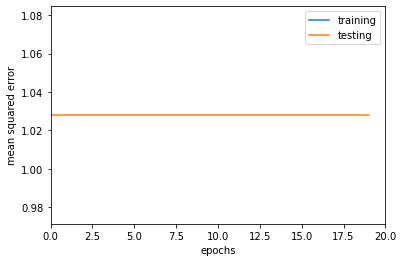

In [188]:
net2 = NeuralNetwork(13, 20, 1, 0.2, activation = 'relu', classifier = False)
net2.train(train_reg, test_reg, max_epochs = 20)